<a href="https://colab.research.google.com/github/rasecotineb/datascience/blob/master/times-series/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trabajo Práctico 4

# Proyecto de Construccion de Modelo de pronóstico ARIMA

A seguir se muestra un ejemplo de construccion de modelo de pronóstico para un dataset <b>robberies.csv</b>, el cual contiene
 informacion mensual de robos a mano armada en la ciudad de Boston desde Enero de 1966 hasta Octubre de 1975 (Creditos de la data a McCleary and Hay (1980)).  La tarea es predecir la cantidad de robos al siguiente mes.
 
 
 Inspeccionemos la data y la partimos: una parte para desarrollo del modelo y otra para validación 

In [ ]:
import pandas as pd
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA
import seaborn; seaborn.set()
plt.rcParams['figure.figsize'] = [10, 8]  #por defecto las figuras se displayan 8 pulgadas de ancho y 6 de alto

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# carga la data y partimos  en dos archivos, uno para preparar el modelo y el otro para validation 
series = pd.read_csv('https://drive.google.com/uc?id=1PK84p-4W3N03Tj-iwu3wQ1WD75Ytqm0N&export=download', header=0, index_col=0, parse_dates=True, squeeze=True)



split_point = len(series) - 12    # 12 puntos  para  validacion (1 año)
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 106, Validation 12


La evaluacion del modelo se hará solo con dataset.csv. Usaremos  La estrategia de evaluacion walk-forward. Separamos 50% para ajustar el modelo inicial y el otro 50% para iterar la evaluacion en walk-forward. En cada iteracion se entrena un modelo y se predice el punto siguiente. Como métrica de evaluacion se usrá RMSE


#### Modelo de Persistencia
Primero haremos un modelo de persistencia para tener un baseline de desempeño

In [ ]:
# evalua un modelo de persistencia
from sklearn.metrics import mean_squared_error
from math import sqrt

# carga la data
series = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)

# prepara la data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)   # 50% para entrenar el modelo inicial
train, test = X[0:train_size], X[train_size:]

# validacion walk-forward
history = train.tolist()  # serie historica para ajustar el modelo. Inicialmente es train

predictions = list()
for i in range(len(test)):
    # predice
    y_predicted = history[-1]  #en el modelo de persistencia la ultima observacion es el valor predicho
    predictions.append(y_predicted)
    
    history.append(test[i])  # agrega la ultima observacion a la historia
    
# reporta el RMSE en test
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 51.844


#### Exploración de la data
Ahora haremos un poco de análisis exploratorio para entender la data. Mostraremos estadisticas, Line Plots, Plots de densidad y Whisker Plots 

count    106.000000
mean     173.103774
std      112.231133
min       29.000000
25%       74.750000
50%      144.500000
75%      271.750000
max      487.000000
Name: 1, dtype: float64


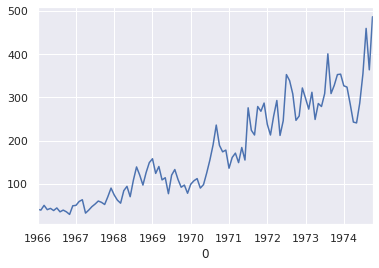

In [ ]:
# Carga los datos e imprime estadisticas sumarias
print(series.describe())

# muestra un line plot de los datos
series.plot()
plt.show()

La media es 173. Podemos considerar que ese es la magnitud de nuestros datos. La desviación estandard es 112, lo cual es relativamente grande. Tambien los percentiles nos dicen que la dispersión de los datos es grande. Podemos esperar cierta dificultad en predecir de forma acurada

El plot nos muestra tendencia en el tiempo. No parece haber outliers evidentes. Hay fluctuaciones  grandes en consonancia con las estadísticas, aunque parece haber mas fluctuaciones en los ultimos años. Podemos inferir con seguridad que la serie es no estacionaria y probablemente no es homoscedástica

Veamos los plots de densidad

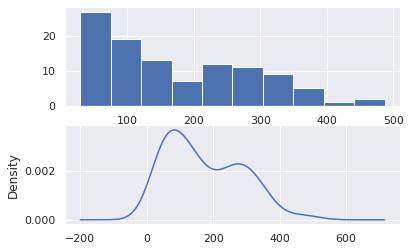

In [ ]:
plt.figure(1)
plt.subplot(211)
series.hist()
plt.subplot(212)
series.plot(kind='kde')
plt.show()

Se puede ver que la distribución es no gausiana y tiene una media diferente de 0. Parece una doble gausiana o una dstribución exponencial.

Veamos los Whisker plots

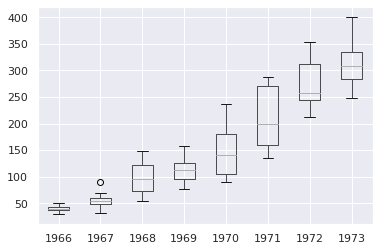

In [ ]:
# boxplots 
#print(series)
groups = series['1966':'1973'].groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.boxplot()
plt.show()

Aparentemente los 2 primeros años tienen un comportamiento diferente de los otros años. Podrian ser candidatos a ser retirados mas adelante 

#### Modelamiento predictivo con modelos ARIMA

De la inspeccion anterior podemos saber que la data es no estacionaria. Veamos si la conseguimos hacer estacionaria por el metodo de diferencias  y haremos tests de estacionariedad

In [ ]:
from statsmodels.tsa.stattools import adfuller

# create una serie de diferencias
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return pd.Series(diff)

# carga la data
series = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = series.values

# usa el metodo de diferencias y obtiene una nueva serie que llamamos stationary
stationary = difference(X)
stationary.index = series.index[1:]

# chequea si es estacionaria
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# salva la serie diferencia en un archivo
stationary.to_csv('stationary.csv', header=False)

ADF Statistic: -3.980946
p-value: 0.001514
Critical Values:
	1%: -3.503
	5%: -2.893
	10%: -2.584


Podemos ver que la serie diferencia es estadisticamente estacionaria. Quiere decir que el modelo necesita hacer al menos diferencias de orden 1 (el parametro d debe ser al menos 1)

Para encontrar los valores p y q del modelo podemos mostrar los plots de autocorrelacion y autocorrelacion parcial de los primeros 50 lags



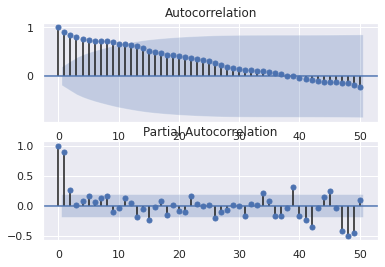

In [ ]:

plt.figure()
plt.subplot(211)
plot_acf(series, lags=50, ax=plt.gca())
plt.subplot(212)
plot_pacf(series, lags=50, ax=plt.gca())
plt.show()

Podemos ver que el ACF muestra correlaciones significantes en los primeros 11 lags. El grafico de PACF muestra los 2 primeros lags como significantes. Esto sugiere un modelo mixto AR y MA. Un punto de partida puede ser $p=3$ y $q=1$.  Con esto, nuestro modelo inicial seria un ARIMA (3,1,1) en la data original. Veamos

In [ ]:
# Carga la data
series = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# evaluacion walk-forward
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(3,1,1))
    model_fit = model.fit(disp=0)
    y_predicted = model_fit.forecast()[0]
    predictions.append(y_predicted)
    history.append(test[i])   # coloca la ultima observacion al historico
    
# reporta RMSE
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 50.295


Es mejor que el modelo de persistencia. Puede haber espacio de mejora 

### Desafio

- Aplicar Grid search con ls siguientes valores de hiperparametros
    p = {0 a 10}
    d = {0 a 2}
    q = {0 a 10}
 
- Despues de encontrar el mejor modelo revisar la serie  residual y ver si su distribucion sigue una gausiana con media 0   y si hay aun autocorrelaciones y autocorrelaciones parciales

- Cómo podria mejorar el modelo?

In [ ]:
# Evalua un modelo ARIMA en estrategia walk-forward para un orden dado (p,d,q) y fraccion de train
def evaluate_arima_model(X, arima_order, train_fraction):
    # prepare training dataset
    train_size = int(len(X) * train_fraction)
    train, test = X[0:train_size], X[train_size:]
    
    # hace las predicciones
    history = train.tolist()  # serie historica para ajustar el modelo. Inicialmente es train
    predictions = list()      # para almacenar las predicciones en test
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order) # crea el modelo ARIMA(p,d,q)
        model_fit = model.fit(disp=0)             # ajusta el modelo a los datos de history
        y_predicted = model_fit.forecast()[0]     # predice el siguiente punto despues de history
        predictions.append(y_predicted)
        history.append( test[t] ) 

    # calculate el RMSE en test
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [ ]:
# evalua de forma grid las combinaciones de p_values, d_values, q_values de un modelo ARIMA
def grid_model_evaluation(series, train_fraction, p_values, d_values, q_values):
    series = series.astype('float32')  # asegura que la serie sea numerica
    best_score, best_cfg = float("inf"), None
    # evaluacion grid
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(series, order, train_fraction)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('Modelo ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    print('Modelo ARIMA{} No se pudo ajustar'.format(order))
                    continue
    print('Mejor modelo: ARIMA%s, RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
import warnings
warnings.filterwarnings("ignore")   # para evitar que muestre constantemente advertencias

train_fraction = 0.66   # los primeros 66% puntos de la serie son para entrenamiento 

# Valores de hiperparametros a evaluar
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 11)

# realiza la evaluacion grid
grid_model_evaluation(X, train_fraction, p_values, d_values, q_values)

Modelo ARIMA(0, 0, 0) RMSE=173.685
Modelo ARIMA(0, 0, 1) RMSE=109.433
Modelo ARIMA(0, 0, 2) RMSE=101.284
Modelo ARIMA(0, 0, 3) No se pudo ajustar
Modelo ARIMA(0, 0, 4) No se pudo ajustar
Modelo ARIMA(0, 0, 5) No se pudo ajustar
Modelo ARIMA(0, 0, 6) No se pudo ajustar
Modelo ARIMA(0, 0, 7) No se pudo ajustar
Modelo ARIMA(0, 0, 8) No se pudo ajustar
Modelo ARIMA(0, 0, 9) No se pudo ajustar
Modelo ARIMA(0, 0, 10) No se pudo ajustar
Modelo ARIMA(0, 1, 0) RMSE=55.099
Modelo ARIMA(0, 1, 1) RMSE=53.615
Modelo ARIMA(0, 1, 2) RMSE=52.568
Modelo ARIMA(0, 1, 3) RMSE=54.235
Modelo ARIMA(0, 1, 4) No se pudo ajustar
Modelo ARIMA(0, 1, 5) No se pudo ajustar
Modelo ARIMA(0, 1, 6) No se pudo ajustar
Modelo ARIMA(0, 1, 7) No se pudo ajustar
Modelo ARIMA(0, 1, 8) No se pudo ajustar
Modelo ARIMA(0, 1, 9) No se pudo ajustar
Modelo ARIMA(0, 1, 10) No se pudo ajustar
Modelo ARIMA(0, 2, 0) RMSE=84.616
Modelo ARIMA(0, 2, 1) RMSE=55.683
Modelo ARIMA(0, 2, 2) No se pudo ajustar
Modelo ARIMA(0, 2, 3) No se pudo 

Se obtienen los hiperparametros (p,d,q) = (10,1,1)

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  105
Model:                ARIMA(10, 1, 1)   Log Likelihood                -514.757
Method:                       css-mle   S.D. of innovations             32.134
Date:                Wed, 09 Sep 2020   AIC                           1055.514
Time:                        19:01:28   BIC                           1090.015
Sample:                             1   HQIC                          1069.494
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3476      0.725      4.617      0.000       1.926       4.769
ar.L1.D.y     -0.1568      0.192     -0.818      0.416      -0.533       0.219
ar.L2.D.y     -0.1906      0.116     -1.640      0.1

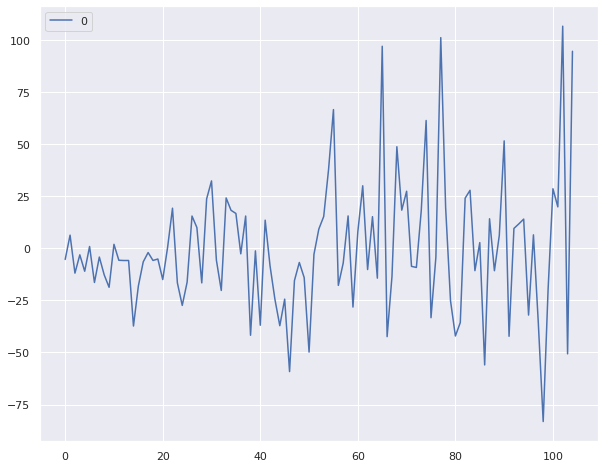

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# Ajusta modelo ARIMA (10,1,1) con la serie dataset
model = ARIMA(X, order=(10,1,1))
model_fit = model.fit(disp=0)

# imprime informacion del modelo ajustado
print(model_fit.summary())

# muestra la serie residual 
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

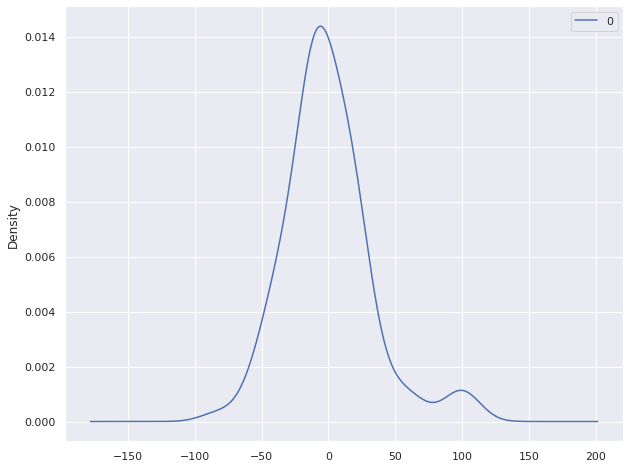

                0
count  105.000000
mean    -0.448367
std     32.320598
min    -83.148340
25%    -16.608004
50%     -5.347637
75%     15.470667
max    106.600937


In [ ]:
# plotea la distribucion de la serie residual 
residuals.plot(kind='kde')
plt.show()

# muestra estadisticas de la serie residual
print(residuals.describe())

La serie residual tiene una media cercana a 0 pero tiene una joroba hacia la cola derecha que podría indicar una anomalía o una particularidad de robos en el tiempo

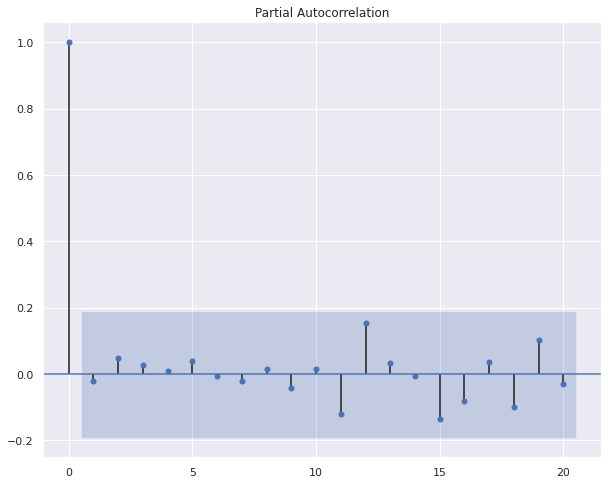

In [ ]:
# Plotea los primeros 20 puntos de la autocorrelacion parcial con plot_pacf() de Statsmodels   
plot_pacf(residuals, lags=20)
plt.show()

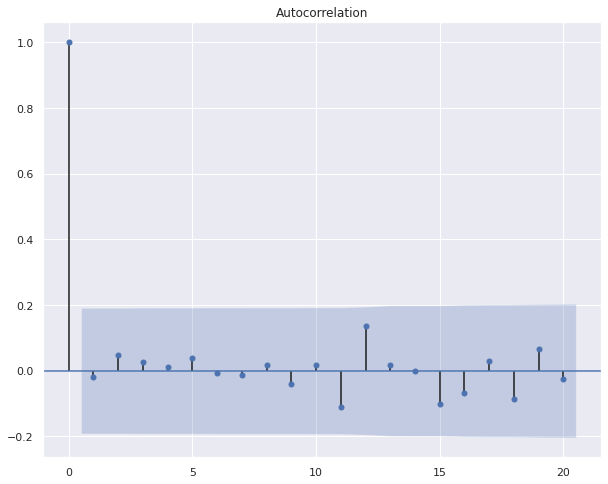

In [ ]:
# Plotea los primeros 20 puntos del correlograma con plot_acf() de Statsmodels   
plot_acf(residuals, lags=20)
plt.show()